# Intro
### что такое word embeddings


___

Если задуматься о том, как кодировать то или иное слово, работая с текстом, то одной из первых догадок выступает one-hot кодирование. Но при использовании такого подхода мы как-будто стираем всю информацию о слове -- о буквах из которых оно состоит, о его похожести на другие слова и проч. Не говоря уже о том, что вектора для one-hot получаются гигантских размерностей, что сказывается еще и на использовании памяти.

Распространенный подход -- сопоставить каждому слову "плотный" вектор (т.е. состоящий не только из всех нулей и единицы).
Т.е. мы как-будто делаем переход из огромного пространства всех слов (dim = [количество слов]) в пространство размерности длины вектора, который мы теперь сопоставляем каждому слову.
Кодирование слов "плотными" векторами и называется "word embeddings".

Cпособов закодировать слова "плотными" векторами можно придумать кучу.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
%matplotlib inline


# рассмотрим простой способ маппинга слов в плотные векторы для примера
# каждому слову из 3х предложений сопоставим вектор длины [количество уникальных слов]
# для каждого слова в соответствующем ему векторе поставим единицы напротив тех слов,
# которые встречаются с ним в одном предложении

s = ['Sky is blue', 'She is getting better', 'Everything is possible']
dic = defaultdict(dict)
for sent in s:
    words = sent.split()
    for w in words:
        for w2 in words:
            dic[w][w2]=1

df = pd.DataFrame(dic)
df.fillna(0, inplace=True)
df

,Everything,She,Sky,better,blue,getting,is,possible
Everything,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
She,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
Sky,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
better,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
blue,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
getting,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
is,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
possible,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0


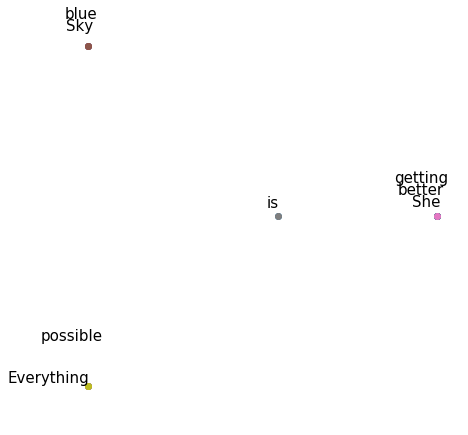

In [2]:
# теперь сожмем эти 8-мерные векторы с помощью PCA
# и отобразим полученные 2-мерные представления на плоскости

res = PCA().fit_transform(df)

font = {'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(res[:,0], res[:,1])
plt.axis('off')
for i, label in enumerate(df.columns):
    x, y = res[i,0], res[i,1]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(label, xy=(x, y),
                 xytext=annot.get(label,(1+i*2, 6*i)), 
                 textcoords='offset points',
                   ha='right', va='bottom', )

Видим, что слова, участвовавшие в одинаковых контекстах стоят ближе друг к другу, а слово '__is__' стоит далеко ото всех, т.к. в данном приближении оно одинаково относится к каждой из 3х групп слов.
___

# word2vec ⟿ skip gram + cbow

Модели __CBOW (Continious Bag of Words)__ и __Skip gram__ были изобретены еще в ныне далеком 2013 году, 
*статья*:
[*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

* Модель __CBOW__ пытается предсказать пропущенное слово по контексту -- т.е. по словам, которые пропущенное слово окружают.
* Модель __skip gram__  -- обратная _CBOW_ -- пытается предсказать контекст по слову.

* Контекст -- это фиксированное количество слов справа и слева от слова в фокусе (см пикчу снизу). Длина контекста определяется параметром, называемым - _окном_.
![context](pics/context.png)
___

Сравнение архитектур 2х моделей в первом приближении

![architecture](pics/architecture.png)

___

Идеи word2vec оказались настолько успешными, что сейчас используются везде где можно и нельзя. И всячески модифицируются.

И, конечно, есть хорошие реализации типа [gensim](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb) которые помогают любому чуваку сразу натренировать качественные модели и сделать нужные ему векторы. Не говоря об огромном количестве мест, где можно скачать уже претренированные векторы.

___


### Немного формализации

### Skip_gram

Пусть у нас есть корпус с последовательностью слов $ w_1, w_2, .., w_T $.

Целевая (Objective function) функция в задаче skip gram сводится к максимизации логарифма вероятности:


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

где $ c $ это длина контекста.

Саму вероятность $ p (w_{t+j} | w_t) $ мы представляем с помощью __Softmax__ -

$$ p (w_o | w_i) = \frac{exp(s(v_i, v_o))}{ \sum^{W}_{w=1}  exp(s(v'^{T} _{w}, v_{w_i} )) } $$


где
* $v_i$ и $v_o$ входной и выходной векторы слов соответственно.
* $s(v_i, v_o) = v'^{T} _{w_o} \cdot v_{w_i}$

Конечно, это очень вычислительно сложно, если словарь большой, поэтому мы и используем **Negative Sampling**, о котором будет рассказано немного позже.

___

### CBOW

Предсказываем уже слово по окружающему его контексту.

$$ E = -log\ p(w_o\ |\ w_{i1},\ w_{i2},\ \dots,\ w_{ic}) $$


И вероятность представляется также как в *skip gram*, только в качестве $v_i$ выступает сумма векторов контекста.

* Input = <сумма слов контекста>

* Output = word-vector

___

Сегодня мы закодим __CBOW__ на tf.

Заданием будет реализовать __`skip gram`__.

___

In [5]:
import tensorflow as tf

В качестве данных мы будем использовать датасет [text8 dataset](http://mattmahoney.net/dc/textdata),

который представляет из себя 100 Мб чистой английской Википедии, выкачанной 3 Марта 2006 года.

# Работа с данными

Для вас она не представляет большого интереса.

Но да, всю самую грязную работу сделали за вас:3

In [3]:
# WARNING! 100 Mb будут скачаны на ваш комп,
# если файлика ./data/text8.zip не существует

import os, urllib
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))

Data at /Users/fogside/Projects/summer_2017/day_09/data/text8.zip.


In [6]:
# Распаковочка и чтение данных

import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print("data_size = {0}".format(len(words)))

data_size = 17005207


In [26]:
# Мы будем строить эмбеддинги только для N = 50000 самых частых слов
# Остальные слова мы пометим как `UNK` (unknown)

from collections import Counter

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(Counter(words).most_common(vocabulary_size-1))
    print("Least frequent word: ", count[-1])
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Все что вам нужно знать об этом датасете тут

print("data: {0}".format(data[:5]))
print("count: {0}".format(count[:5]))
print("word_to_index: {0}".format(list(word_to_index.items())[:5]))
print("index_to_word: {0}".format(list(index_to_word.items())[:5]))

Least frequent word:  ('hif', 9)
data: [5234, 3081, 12, 6, 195]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
word_to_index: [('UNK', 0), ('the', 1), ('of', 2), ('and', 3), ('one', 4)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one')]


In [27]:
import numpy as np
from collections import deque

def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print("bag_window = {0}".format(bag_window))
    print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
bag_window = 1
batch = [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
labels = ['originated', 'as', 'a', 'term']

bag_window = 2
batch = [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
labels = ['as', 'a', 'term', 'of']



____

А теперь просто внимательно взгляните на вывод.

* Напомню, сейчас мы хотим закодить _CBOW_, а потому в качестве `labels` у нас выступает пропущенное слово.

* Вспомните про параметр __окно__, обсуждавшийся выше, здесь это __`bag_window`__.

* Каждый сэмпл в батче имеет количество слов, равное __`bag_window * 2`__
___

# Архитектура CBOW на TF

Пришло время писать код модели. Но для начала небольшое пояснение по поводу функции лосса, которая тут используется.

[**sampled_softmax_loss**](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) используется как правило в случаях, когда присутствует огромное количество классов. 
Эта функция расчитывает вероятности принадлежности к определенным классам с помощью *`softmax`*, а затем вычисляет *`cross_entropy`*.

Здесь важное понятие **`Negative sampling`**. Если не использовать никаких трюков и делать все честно, то вероятности будут считаться по всему словарю и обновление весов в матрице эмбеддингов будет происходить для всех-всех слов в словаре для каждого сэмпла, подаваемого модели на вход при тренировке.

Это очень вычислительно затратно. Поэтому было предложено для каждого положительного класса, который должен быть предсказан в текущий момент времени, выбирать всего лишь несколько негативных примеров, которые выбираются случайно. Таким образом каждый сэмпл будет заставлять обновляться лишь небольшое число векторов в матрице эмбеддингов (в tf по дефолту контролируется, чтобы случайно выбранный негативный пример не совпадал с текущим положительным классом).

Ребята из гугла, которые это придумали, также показали, что такой подход позволяет обучаться не только быстрее, но и лучше.
Подробнее можно прочесть [здесь](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).

In [9]:
import math

# Задаем константы
batch_size = 128
embedding_size = 128

# Сколько слов рассматривать с каждой стороны
bag_window = 2
# Сколько негативных примеров давать для sampled_softmax_loss
num_sampled = 64

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    #
    # Берем на входе вектора для слов контекста, которых всего bag_window * 2
    train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
    # Лейбл -- это слово в середине
    train_labels = tf.placeholder(tf.int32, [batch_size, 1])
    
    #
    # Cоздаем матрицу эмбеддингов;
    # Инициализируем сэмплированием из равномерного распределения [-1, 1]
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    # 
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], \
                                                      stddev = 1.0 / math.sqrt(embedding_size)), )
    #
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #
    # C помощью этой операции достаем нужные векторы из матрицы эмбеддингов
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    
    #
    # Складываем полученные вектора всех слов в окружении в один вектор
    embed_sum = tf.reduce_sum(embed, 1)
    
    # Самое интересное -- это loss, о нем подробнее читайте выше
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    # Нам необходимо нормализовывать вектора эмбеддингов, 
    # чтобы можно было адекватно строить косинусные расстояния
    # и сразу в процессе тренировки наблюдать как оно там все обучается и какие слова друг к другу близки
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm

# Обучаем

Для 8 тыс шагов на 2х полноценных ядрах CPU + 2 ядра с гипертредингом мне потребовалось 17 минут 27 секунд.

Но этого времени явно недостаточно, чтобы обучить полноценные эмбеддинги.

По-хорошему, с хотя бы 50 тыс. итераций результат должен был бы выглядеть значительно лучше. Но на это потребуется порядка 2 часа обучения на CPU с похожей конфигурацией.

In [17]:
%%time
#num_steps = 50001
num_steps = 8001

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    
    for step in range(num_steps):
        _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
        feed_dict = { train_data: batch, train_labels: labels }
        _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += current_loss
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                print ("step = {0}, average_loss = {1}".format(step, average_loss))
                average_loss = 0
    
    final_embeddings = normalized_embeddings.eval()

Initialized
step = 2000, average_loss = 0.19910021030411007
step = 4000, average_loss = 0.0004236186837333662
step = 6000, average_loss = 0.000114050094563936
step = 8000, average_loss = 6.479442591853513e-05
CPU times: user 37min 39s, sys: 12min 28s, total: 50min 7s
Wall time: 17min 27s


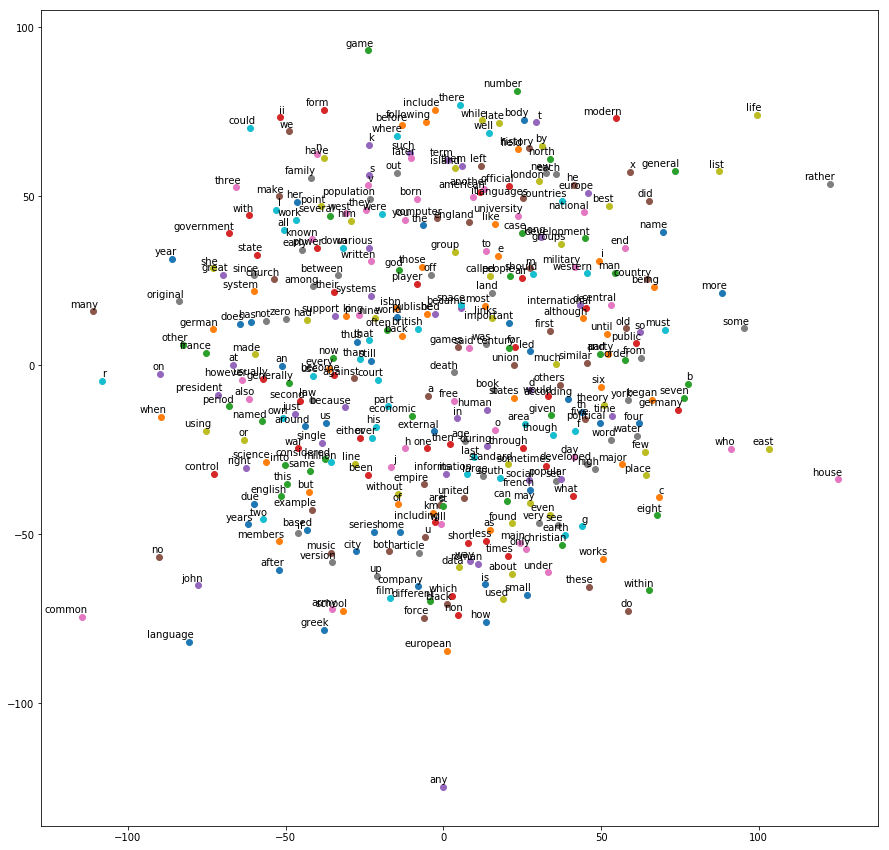

In [30]:
from sklearn.manifold import TSNE

num_points = 350

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

pylab.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

# Задание

Нужно реализовать skip-gram, немного исправив код выше.

В данном случае подход очень хорошо иллюстрируется такой картинкой.

![skip_gram](pics/training_data.png)

---
Тут видно, что на самом деле обучающая выборка строится из пар слов -- (<центральное слово>, <слово рядом>).

Т.е. модель принимает на вход <центральное слово> и должна подсветить класс, соответствующий <слову рядом>.

Получается, что отличие между моделями совсем небольшое. Осталось только отразить это в коде.

In [30]:
# Генерилка батчей сделана за вас:)
from collections import deque
import numpy as np
import random

def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

data_index = 11, num_skips = 2, skip_window = 1
batch = ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
labels = ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'first', 'against']

data_index = 9, num_skips = 4, skip_window = 2
batch = ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
labels = ['a', 'anarchism', 'originated', 'term', 'term', 'as', 'of', 'originated', 'a', 'of', 'as', 'abuse', 'term', 'abuse', 'a', 'first']



In [ ]:
< здесь должен быть код на tf, который делает skip-gram модель >

In [ ]:
< здесь должен быть код на tf, который запускает обучение skip-gram модели >

In [ ]:
< здесь должен быть код визуализации полученных эмбеддингов с помощью TSNE >

# fastText

Сейчас мы посмотрим на некоторые возможности библиотечки [fastText](https://github.com/facebookresearch/fastTextm) от Facebook. Статья по теме _unsupervised learning_ с fasttext: [link](https://arxiv.org/pdf/1607.04606v1.pdf)

* Она была анонсирована в 2016 и позволяет обучать эмбеддиги и делать классификацию текста. Умеет работать с Out-of-vocabulary словами благодаря обучению n-gram.

* Библиотека реализована на C++. [Питоновский интерфейс](https://pypi.python.org/pypi/fasttext) к ней существует, но официально не поддерживается.

* Тем не менее, fasttext можно установить через pip: `pip install fasttext`
* fastText очень быстро позволяет обучить эмбеддинги даже для довольно больших текстов по сравнению с другими методами.
* fastText работает лучше gensim на маленьких корпусах.
* fastText не является stand-alone NLP библиотекой, т.к. для препроцессинга использует другие библиотеки.


Подход к обучению embeddings у fastText несколько иной, чем было разобрано выше.

В основе лежит тот же [skip gram](#Skip_gram) и  [CBOW](#CBOW), но в формализации вероятности с помощью _Softmax_ используется несколько иная функция $s$.

Пусть $G$ -- это набор n-грамм, которые можно получить из слова $w$ путем выбора n рядом стоящих букв. Причем к слову прибавим слева и справа специальные символы "<" и ">" чтобы обозначить префиксы и суффиксы.

Тогда разбиение будет выглядить следующим образом для n=3 и w = "< where >" получим набор:  "< wh", "whe", "her", "ere", "re >" + само слово "< where >" также включаем в этот набор.

Сопоставляя каждому элементу $g \in G$ свой вектор $z_g$ мы получаем функцию скоринга $s$, которую уже подставляем в выражение _Softmax_ как в [skip gram](#Skip_gram) или [CBOW](#CBOW)

$$s = \sum_{g \in G_w}  z_g^{T}  \cdot  v_{c}  $$

Т.к. каждому слову, которого нет в словаре, можно сопоставить сумму векторов n-gram, из которых слово состоит, то проблема с Out_of_vocabulary здесь решается.

___

__Инструкция для установки fastText для использования в качестве command line tool:__

        git clone https://github.com/facebookresearch/fastText.git
        cd fastText
        make

In [2]:
import fasttext

Посмотрим сколько времени требуется для обучения эмбеддингов на fastText для CBOW & skip gram моделей.

**!WARNING!:** *на диск сохраняется модель весом 800 Мб примерно*

Параметры следующие:

    **For Skipgram, CBOW**
    
    input          training file path
    output         output file path
    lr             learning rate [0.05]
    lr_update_rate change the rate of updates for the learning rate [100]
    dim            size of word vectors [100]
    ws             size of the context window [5]
    epoch          number of epochs [5]
    min_count      minimal number of word occurences [1]
    neg            number of negatives sampled [5]
    word_ngrams    max length of word ngram [1]
    loss           loss function {ns, hs, softmax} [ns]
    bucket         number of buckets [2000000]
    minn           min length of char ngram [3]
    maxn           max length of char ngram [6]
    thread         number of threads [12]
    t              sampling threshold [0.0001]
    silent         disable the log output from the C++ extension [1]


In [5]:
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

Можно обучить эмбеддинги для текста воспользовавшись python-оберткой от fasttext:
    
    model = fasttext.skipgram('./data/text8', MODELS_DIR+'model_skipGram')
    # или так
    model = fasttext.cbow('./data/text8',  MODELS_DIR+'model_cbow')
    
Или можно воспользоваться command line интерфейсом, который предлагают авторы.
Но в последнем случае возникают сложности с совместимостью полученной модели и питонячей оберткой.

    # Как альтернатива питоновской обертке можно использовать fasttext непосредственно, установив его из git;
    # Но тогда обученная модель будет слишком новой для питоновской обертки fasttext, которую поддерживают энтузиасты.

    lr = 0.05
    dim = 100
    ws = 5
    epoch = 5
    minCount = 11
    neg = 5
    loss = "ns"
    t = 1e-4
    corpus_file = './data/text8'
    output_file = 'text8'
    FS_HOME = '~/fastText/'


    %time !~/fastText/fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file} -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}


In [7]:
%%time
model = fasttext.cbow('./data/text8',  MODELS_DIR+'model_cbow', min_count=11)

#** Подргрузить обученную модель можно так **
# model = fasttext.load_model('./models/model_cbow.bin')

In [10]:
model.cosine_similarity("queen", "princess")

0.6084227657803134

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

queen = np.array(model["king"]) - np.array(model["men"]) + np.array(model["women"])
cosine_similarity(queen, model["queen"])

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.49980556]])

In [12]:
model.cosine_similarity("queen", "king")

0.58017797413856853

In [14]:
model.cosine_similarity("Russia", "banana")

0.095215028970238633

In [40]:
model.cosine_similarity("kit", "cat")

0.34026856208560913

In [41]:
model.cosine_similarity("wolf", "carrot")

0.34755412993005647

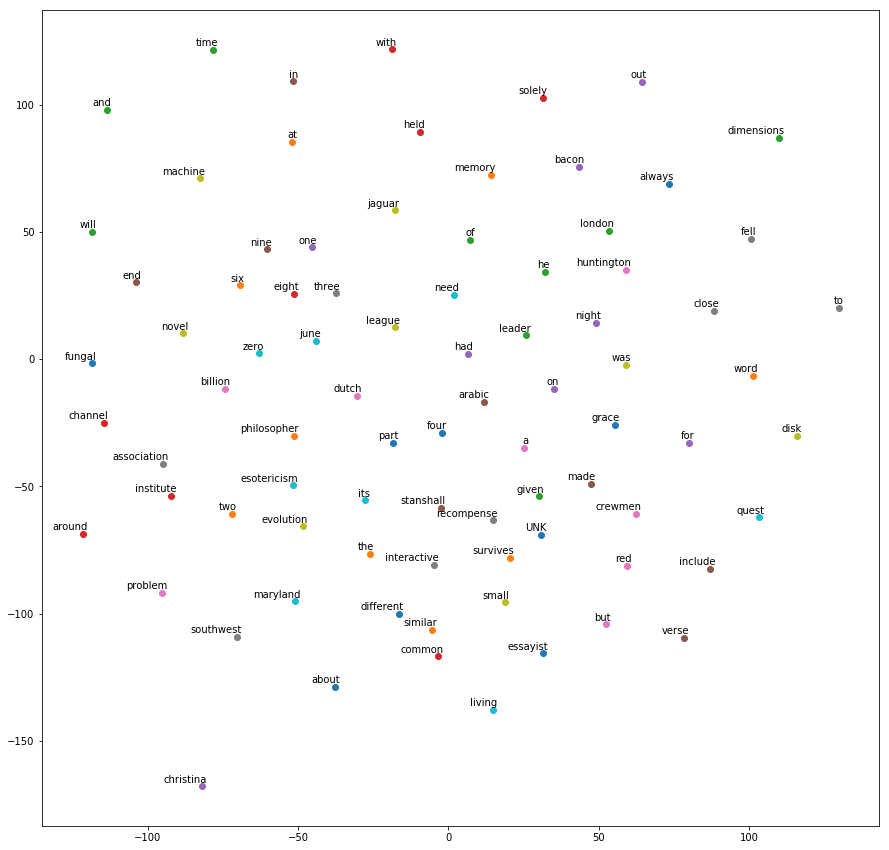

In [35]:
tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)

random_points = list(set(random.sample(data,100)))
random_points = [index_to_word[each] for each in random_points]
random_points_mtx = np.array([model[word] for word in random_points])

two_d_embeddings = tsne.fit_transform(random_points_mtx)

plt.figure(figsize=(15,15))

for i, label in enumerate(random_points):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()